<a href="https://www.kaggle.com/code/sameergururajmathad/dsc-540-final-project?scriptVersionId=271623978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Author:

##### *Sameer Gururaj Mathad*

### Collaborators:

##### *Atta Yaw Agyeman*

##### *Sneha Thallapaka*

##### *Joseph Giwa*

### DataSet Selection

##### *Sneha Thallapaka*

In [1]:
from IPython.display import display

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from scipy.stats import chi2_contingency

# sklearn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

# Importing XGboost algorithm
import xgboost as xgb


# Kaggle start up code
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/lung-cancer-risk-and-prediction-dataset/lung_cancer_prediction.csv


In [2]:
class Visualize:
    '''
    Class for visualizing categorical variables(as of now)
    '''
    def __init__(self):
        self.colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'cyan', 'teal']
    
    def __pie(self, feature: np.ndarray | pd.Series, colors:list[str], explode:bool)->None:
        '''
        Function to plot pie chart using plt.
        '''
        explosion = [0] * len(feature)
        if explode:
            explosion = [0.05  if x == 'nan' else 0 for x in feature.index]
        plt.pie(
            x=feature.values,
            labels=feature.index,
            autopct= '%1.1f%%',
            colors= colors,
            explode = explosion,
            wedgeprops={"alpha": 0.4}
        )

    
    def __bar(self,feature: np.ndarray | pd.Series, colors:list[str])->None:
        '''
        Function to plot pie chart using plt.
            
        '''
        plt.bar(x=feature.index, height = feature.values, color= colors , label = feature.index,  alpha= 0.5)
        plt.legend()
        plt.xticks(rotation=45)

    def __category(self, feature: np.ndarray | pd.Series, title: str, explode_na:bool=True)->None:
        '''
        Method to plot both pie and bar graphs. If the number of categories is large, then by default plots bar graph.
        '''
        target_labels_count = feature.value_counts(dropna=False).sort_values()
        target_labels_count_length = len(target_labels_count.values)
        # Convert all values into string to make sure NaN is included
        target_labels_count.index = target_labels_count.index.map(lambda x: str(x))
        colors = np.random.choice(self.colors, size=target_labels_count_length, replace=len(self.colors) <= target_labels_count_length)
        if len(self.colors) <= target_labels_count_length:
            plt.figure(figsize=(20, 8))
            plt.title(title)
            return self.__bar(target_labels_count, colors)
        plt.suptitle(title)
        plt.subplot(121)
        self.__pie(target_labels_count, colors, explode_na)
        plt.subplot(122)
        self.__bar(target_labels_count, colors)
        plt.tight_layout()
        plt.show()
    
    def feature(self, feature: np.ndarray | pd.Series, explode_na:bool=True)->None:
        '''
        Method that initites the plotting. Should be invoked in order to plot both bar graph and pie chart.
        '''
        title = f'{feature.name} <---> {feature.dtype}'.title()
        return self.__category(feature,title, explode_na)
        # if feature.dtype in ['object', 'category']:
        #     return self.__category(feature,title, explode_na)
        # else:
        #     return 'Not available for other data types'
        
        

In [3]:
class Sampler:
    '''
    This class handles sampling.
    '''
    def load(self, df, target_column):
        self.df = df
        self.target_column = target_column
        
    def compute_weights(self, label_series: pd.Series)->pd.Series:
        '''
        This method is used internally to compute weights for sampling.
        '''
        label_count = label_series.value_counts()
        label_count = label_count.values / sum(label_count)
        noise = np.random.randint(1, 5)
        print(f'Random noise added: {noise}')
        label_count *= -1 * noise
        label_count = np.round(tf.nn.softmax(label_count),2)
        label_series = label_series.apply(lambda x: label_count[x])
        return label_series

    def random_sampling(self, n_samples:int, weighted: bool = False)->list[np.ndarray]:
        '''
        Plain random sampling
        '''
        weights = None
        if weighted:
            weights = self.compute_weights(self.df[self.target_column])
        df = self.df.sample(n=n_samples, replace=False, weights = weights)
        return df.iloc[:, :-1], df.iloc[:, -1]
        
    def sampling_w_replacement(self, weighted: bool = False)->list[np.ndarray]:
        '''
        Sampling with replacement, same as random_sampling but the sampled instances are replaced.
        '''
        weights = None
        if weighted:
            weights = self.compute_weights(self.df[self.target_column])
        df = self.df.sample(frac = 1, replace = True, weights = weights)
        return df.iloc[:, :-1], df.iloc[:, -1]

    def stratified_eq_sampling(self, n_samples:int)->list[np.ndarray]:
        '''
        Stratified sampling to sample specified distribution. In our case we want 50% or equal percentage of class labels.
        '''
        if n_samples % 2 != 0:
            print('Adding one to make sample size even')
            n_samples += 1
        grouped_df = self.df.groupby(self.target_column, observed = False)
        stratified_df = grouped_df.apply(lambda x: x.sample(n = n_samples, replace = True), include_groups = False)
        stratified_df = stratified_df.droplevel(level = 1)
        stratified_df = stratified_df.reset_index()
        return stratified_df.iloc[:, 1:], stratified_df.iloc[:, 0]
        
    def smote(self, X, y, sampling:str = 'all', neighbors:int = 5)->list[np.ndarray]:
        '''
        Smote method. Uses imbalance-learn.
        '''
        smt = SMOTE(sampling_strategy = sampling, k_neighbors = neighbors)
        return smt.fit_resample(X, y)

In [4]:
class Preprocess:
    '''
    Class for parsing, pretty printing and preprocessing the dataset.
    All methods here calls the display method, to display result as a dataframe.
    '''
    
    def display(self, data: dict| pd.DataFrame):
        if type(data) == 'pandas.core.frame.DataFrame':
            display(data)
        else:
            display(pd.DataFrame(data = data))
        
    def column_dtypes(self, df: pd.DataFrame)->None:
        '''
        Method to display column names and its respective data types as a dataframe.
        '''
        columns = list(df.columns)
        dtypes = list(df.dtypes)
        self.display({'Columns': columns, 'Dtypes': dtypes})

    def category_unique_values(self, df: pd.DataFrame)->None:
        '''
        Method to display category column names and its number of unique values as a dataframe.
        '''
        unique_values_count = []
        features = []
        for column in df.columns:
            if df[column].dtype == 'object':
                features.append(column)
                unique_values_count.append(df[column].nunique())
        self.display({'Columns': features, 'Unique Values': unique_values_count})
        

    def as_dtype(self, df: pd.DataFrame, _from, _to)->pd.DataFrame:
        '''
        Method to convert a columns dtype from one type to another. Advantage is, it works on all the columns in the dataframe 
        having same dtype of focus
        '''
        for column in df.columns:
            if df[column].dtype == _from:
                df[column] = df[column].astype(_to)
        return df

    def has_nan(self, df: pd.DataFrame)->list[str]:
        '''
        Method to display column names and whether it contains null values as a dataframe.
        '''
        has_na = []
        na_present = []
        for index, column in enumerate(df.columns):
            decision = df[column].hasnans
            has_na.append(decision)
            if decision:
                na_present.append(column)
        self.display({'Columns': list(df.columns), 'has_NaN': has_na})
        return na_present
        
    def check_category_correlation(self, df:pd.DataFrame, variable:str, p_value:int)->list:
        '''
        Method used to compute correlation between category variables. Highlights feature dependancy.
        '''
        result = []
        for column in df.columns:
            if df[column].dtype in ['object', 'category'] and column != variable:
                contingency_table = pd.crosstab(df[column], df[variable])
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                if p < p_value:
                    result.append((column, p, dof))
        return result

    def standardize(self,df:pd.DataFrame | np.ndarray)->pd.DataFrame:
        '''
        Method for standardizing the input. Uses StandardScaler from sklearn.
        '''
        norm = StandardScaler()
        return norm.fit_transform(df)

    def normalize(self,df:pd.DataFrame | np.ndarray)->pd.DataFrame:
        '''
        Method for normalizing the input. Uses MinMaxScaler from sklearn.
        '''
        norm = MinMaxScaler()
        return norm.fit_transform(df)
    
    def __onehot(self, df:pd.DataFrame)->pd.DataFrame:
        '''
        Method for one-hot encoding the input using pandas get_dummies.
        '''
        return pd.get_dummies(df, dtype=int)

    def __label(self, feature: pd.Series)->pd.Series:
        '''
        Method for label encoding the input. Uses LabelEncoded from sklearn.
        '''
        label_encoder = LabelEncoder()
        return label_encoder.fit_transform(feature) 

    def __label_all(self, df:pd.DataFrame)->pd.DataFrame:
        '''
        Method for label encode the whole DataFrame rathere than a single column. Uses LabelEncoded from sklearn.
        '''
        new_df = df.copy()
        for column in new_df.columns:
            if new_df[column].dtype in ['object', 'category']:
                new_df[column] = self.__label(new_df[column])
        return new_df
         
    def encode(self, df:pd.DataFrame, _type: str = 'Label')->pd.DataFrame:
        '''
        Factory method to invoke type of encoding based on _type value.
        '''
        match(_type):
            case 'OneHot': 
                target_column = df.columns[-1]
                new_df = self.__onehot(df.iloc[:, :-1])
                new_df[target_column] = self.__label(df.iloc[:-1])     
                return new_df
            case 'Label':
                return self.__label_all(df)
            case _: return 'Not Supported!!'

In [5]:
class Pipeline:
    '''
    Pipeline to run models.
    '''
    def __init__(self):
        self.models = {}

    def initialize(self, X:np.ndarray | pd.DataFrame, y: np.ndarray | pd.Series, normalizer, test_size:int = 0.3):
        '''
        Inititalize the pipeline with X and y along with normalizer and test_size
        '''        
        self.X = normalizer(X)
        self.y = y
        self.train_X, self.test_x, self.train_y, self.test_y = train_test_split(dt_X, dt_y, test_size = test_size)

    def load(self, model_name:str, model:any)->None:
        '''
        Load the model of choice.
        '''
        self.models[model_name] = model

    def unload(self, model_name:str)->None:
        '''
        Unload a model of choice.
        '''
        if model_name in self.models:
            del self.models[model_name]

    def reset(self):
        '''
        Reset the pipeline.
        '''
        self.models = {}

    def process(self)->None:
        '''
        This method is used to run all the models present to fit train data and predict test data.
        '''
        for model_name, model in self.models.items():
            model.fit(self.train_X, self.train_y)
            predictions = np.round(model.predict(self.test_x))
            predictions = (predictions >= 0.5).astype(int)
            self.report(model_name, predictions, self.test_y)

    def report(self, model_name:str,  y_pred:np.ndarray, y_actual:np.ndarray)->None:
        '''
        Used internally for reporting by process method.
        '''
        print(f'---------------{model_name}---------------')
        print(classification_report(y_pred, y_actual, zero_division = 0))
        print('\n\n')


#### Read csv file using pandas api

In [6]:
_df = pd.read_csv('/kaggle/input/lung-cancer-risk-and-prediction-dataset/lung_cancer_prediction.csv')

#### Object creation

In [7]:
vz = Visualize()
prep = Preprocess()
sampler = Sampler()
pipe = Pipeline()

#### Shape of the dataset. The dataset consists of *4,60,292* rows and *25* columns.

In [8]:
_df.shape

(460292, 25)

In [9]:
_df

,Country,Age,Gender,Smoking_Status,Second_Hand_Smoke,Air_Pollution_Exposure,Occupation_Exposure,Rural_or_Urban,Socioeconomic_Status,Healthcare_Access,...,Treatment_Access,Clinical_Trial_Access,Language_Barrier,Mortality_Risk,5_Year_Survival_Probability,Delay_in_Diagnosis,Family_History,Indoor_Smoke_Exposure,Tobacco_Marketing_Exposure,Final_Prediction
0,Russia,82,Male,Former Smoker,Yes,Medium,No,Urban,High,Limited,...,Partial,Yes,No,0.263278,0.797576,Yes,No,No,No,No
1,Thailand,66,Female,Former Smoker,No,High,No,Rural,Middle,Good,...,Partial,Yes,No,0.154697,0.336674,Yes,No,No,Yes,No
2,Colombia,87,Male,Former Smoker,No,Medium,No,Urban,Low,Poor,...,Partial,Yes,No,0.607435,0.063621,No,No,No,Yes,No
3,Egypt,51,Female,Former Smoker,No,Low,Yes,Rural,High,Good,...,Full,No,No,0.081184,0.336814,No,No,No,Yes,No
4,DR Congo,43,Male,Former Smoker,No,High,No,Urban,Middle,Good,...,Full,No,No,0.643276,0.820103,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460287,Russia,46,Female,Former Smoker,Yes,Medium,No,Urban,Middle,Poor,...,Partial,No,No,0.794849,0.521195,No,No,No,No,Yes
460288,Pakistan,63,Female,Non-Smoker,No,Low,No,Urban,Middle,Good,...,Partial,No,No,0.198008,0.907028,No,No,No,No,Yes
460289,Germany,51,Female,Smoker,No,Low,No,Urban,High,Poor,...,Partial,No,No,0.491532,0.866276,Yes,Yes,No,Yes,No
460290,Italy,83,Female,Former Smoker,No,Low,No,Urban,Middle,Good,...,Full,No,No,0.077730,0.610409,No,No,No,No,Yes


In [10]:
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460292 entries, 0 to 460291
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Country                      460292 non-null  object 
 1   Age                          460292 non-null  int64  
 2   Gender                       460292 non-null  object 
 3   Smoking_Status               460292 non-null  object 
 4   Second_Hand_Smoke            460292 non-null  object 
 5   Air_Pollution_Exposure       460292 non-null  object 
 6   Occupation_Exposure          460292 non-null  object 
 7   Rural_or_Urban               460292 non-null  object 
 8   Socioeconomic_Status         460292 non-null  object 
 9   Healthcare_Access            460292 non-null  object 
 10  Insurance_Coverage           460292 non-null  object 
 11  Screening_Availability       460292 non-null  object 
 12  Stage_at_Diagnosis           460292 non-null  object 
 13 

#### Target variable distribution

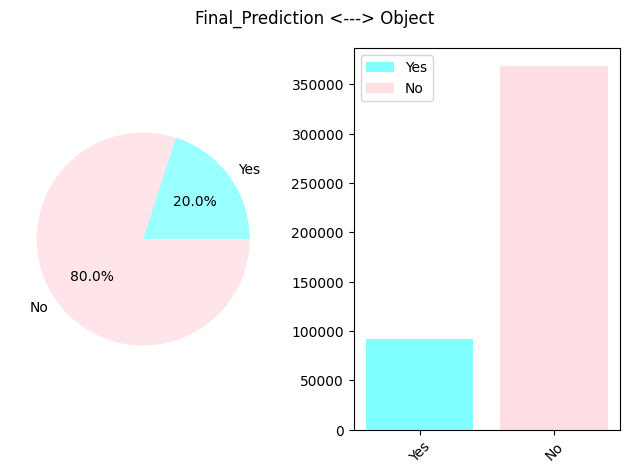

In [11]:
vz.feature(_df['Final_Prediction'])

In [12]:
_df['Final_Prediction'].value_counts()

Final_Prediction
No     368107
Yes     92185
Name: count, dtype: int64

#### Displaying the column names.

In [13]:
prep.column_dtypes(_df)

,Columns,Dtypes
0,Country,object
1,Age,int64
2,Gender,object
3,Smoking_Status,object
4,Second_Hand_Smoke,object
5,Air_Pollution_Exposure,object
6,Occupation_Exposure,object
7,Rural_or_Urban,object
8,Socioeconomic_Status,object
9,Healthcare_Access,object


#### Check the number of unique elements in each column 

In [14]:
prep.category_unique_values(_df)

,Columns,Unique Values
0,Country,30
1,Gender,2
2,Smoking_Status,3
3,Second_Hand_Smoke,2
4,Air_Pollution_Exposure,3
5,Occupation_Exposure,2
6,Rural_or_Urban,2
7,Socioeconomic_Status,3
8,Healthcare_Access,3
9,Insurance_Coverage,2


#### Convert each of these columns into categories since they are within the range of 30

In [15]:
_df = prep.as_dtype(_df, _from ='object', _to='category')

In [16]:
prep.column_dtypes(_df)

,Columns,Dtypes
0,Country,category
1,Age,int64
2,Gender,category
3,Smoking_Status,category
4,Second_Hand_Smoke,category
5,Air_Pollution_Exposure,category
6,Occupation_Exposure,category
7,Rural_or_Urban,category
8,Socioeconomic_Status,category
9,Healthcare_Access,category


In [17]:
_df.describe()

,Age,Mortality_Risk,5_Year_Survival_Probability
count,460292.000000,460292.000000,460292.000000
mean,60.044183,0.500113,0.499866
std,17.590029,0.259828,0.260258
min,30.000000,0.050002,0.050001
25%,45.000000,0.274948,0.274252
50%,60.000000,0.500361,0.499002
75%,75.000000,0.725412,0.726071
max,90.000000,0.949997,0.949998


#### Now, we need to verify whether the dataset consists of null or garbage values.

In [18]:
null_detected = prep.has_nan(_df)

,Columns,has_NaN
0,Country,False
1,Age,False
2,Gender,False
3,Smoking_Status,False
4,Second_Hand_Smoke,False
5,Air_Pollution_Exposure,False
6,Occupation_Exposure,False
7,Rural_or_Urban,False
8,Socioeconomic_Status,False
9,Healthcare_Access,False


#### Before proceeding, we can check categories that correlate by using Chi-Square test

In [19]:
print('Chi-square test')
for column in _df.columns:
    if _df[column].dtype in ['object', 'category']:
        dependent_variables = prep.check_category_correlation(_df, column, 0.1)
        print(f'-----------{column}-----------')
        for dv in dependent_variables:
            print(dv)
        print('\n\n')

Chi-square test
-----------Country-----------
('Smoking_Status', 0.08802032081335802, 58)
('Rural_or_Urban', 0.06456711912491708, 29)
('Tobacco_Marketing_Exposure', 0.004959033462659222, 29)
('Final_Prediction', 0.016550112699433905, 29)



-----------Gender-----------
('Smoking_Status', 0.03110182606699148, 2)



-----------Smoking_Status-----------
('Country', 0.08802032081335817, 58)
('Gender', 0.0311018260669915, 2)
('Second_Hand_Smoke', 0.004391697911966762, 2)
('Healthcare_Access', 0.08339085999371428, 4)
('Screening_Availability', 0.05331830887247507, 2)



-----------Second_Hand_Smoke-----------
('Smoking_Status', 0.004391697911966762, 2)



-----------Air_Pollution_Exposure-----------
('Indoor_Smoke_Exposure', 0.08588816371413728, 2)
('Tobacco_Marketing_Exposure', 0.02561056424753396, 2)
('Final_Prediction', 0.02877305378732323, 2)



-----------Occupation_Exposure-----------
('Socioeconomic_Status', 0.020949701165321147, 2)



-----------Rural_or_Urban-----------
('Country', 

#### Visualization of features which the target variable is dependent on

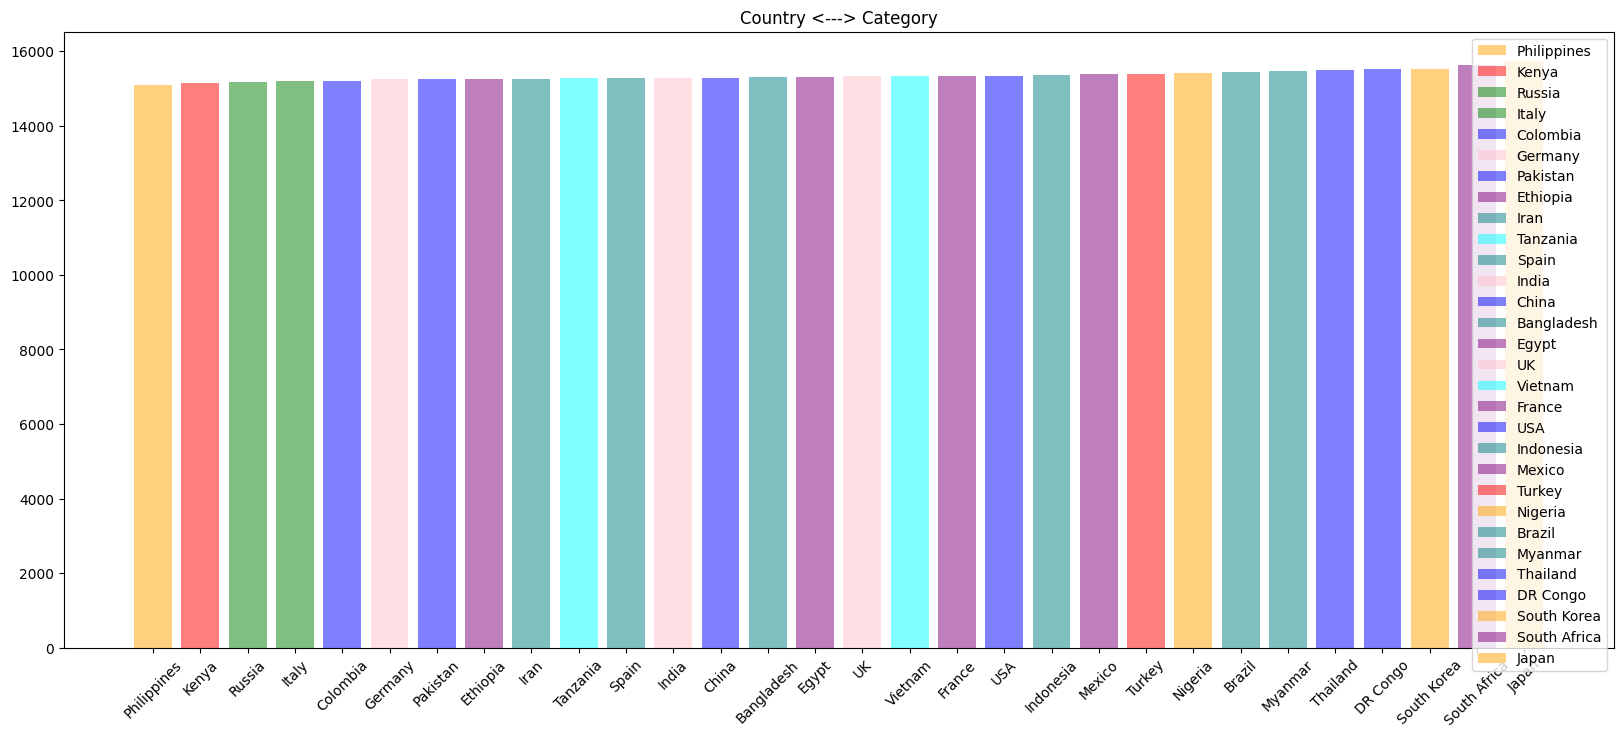

In [20]:
vz.feature(_df['Country'])

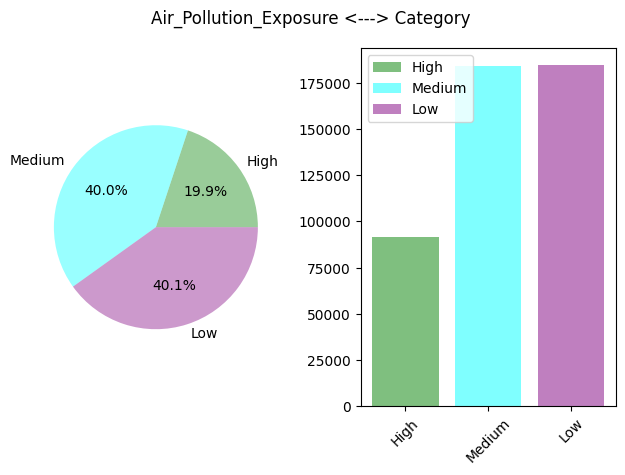

In [21]:
vz.feature(_df['Air_Pollution_Exposure'])

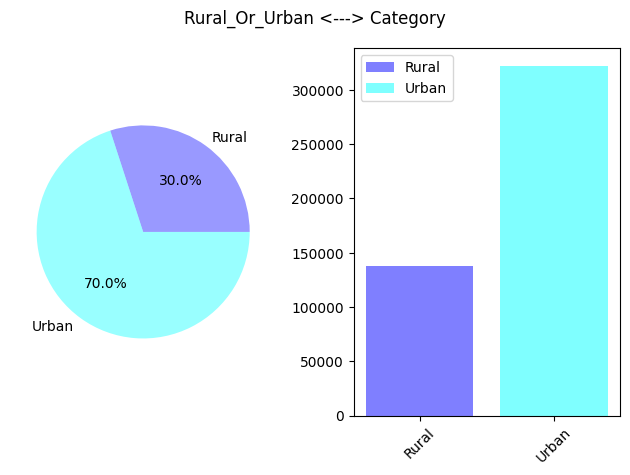

In [22]:
vz.feature(_df['Rural_or_Urban'])

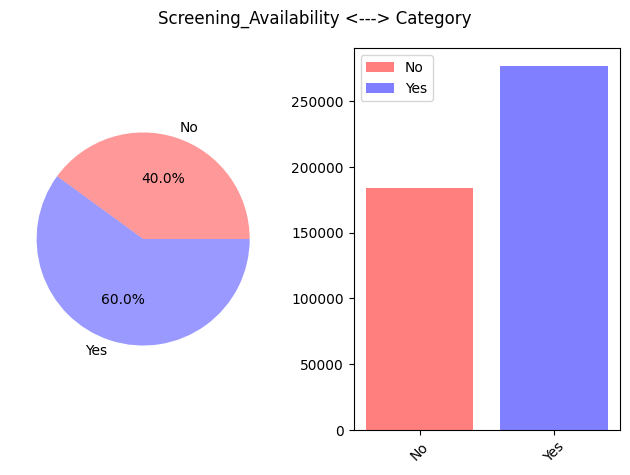

In [23]:
vz.feature(_df['Screening_Availability'])

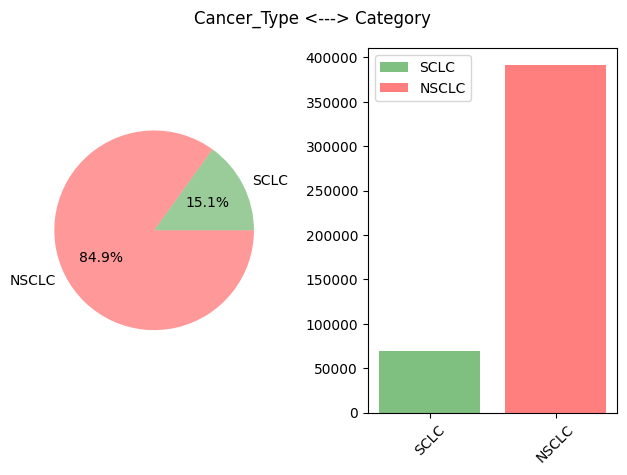

In [24]:
vz.feature(_df['Cancer_Type'])

#### Visulizing features having null values

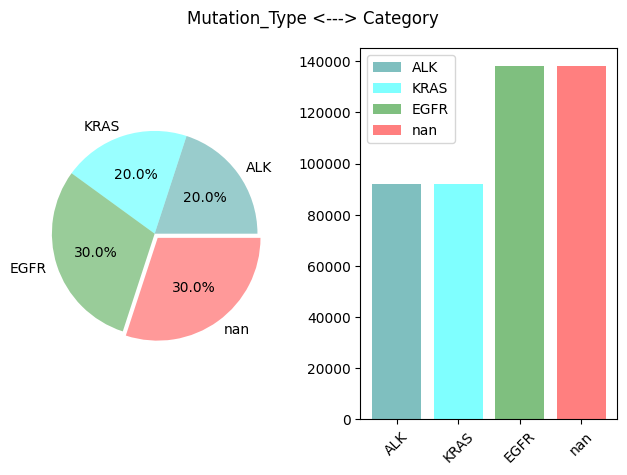

In [25]:
vz.feature(_df['Mutation_Type'])

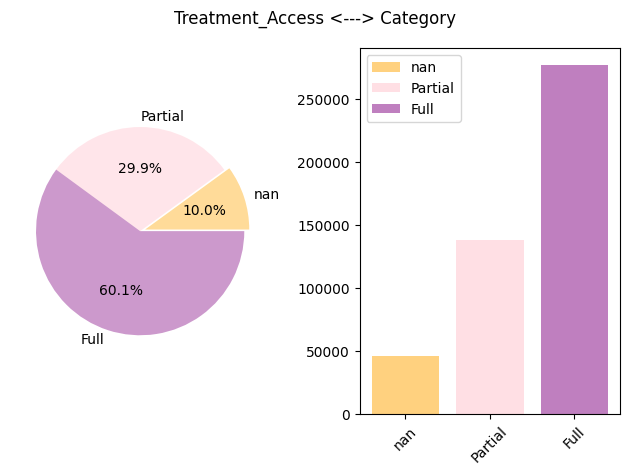

In [26]:
vz.feature(_df['Treatment_Access'])

## Part 1: Selecting all columns by dropping rows consisting null values

In [27]:
population_1 = _df[~_df['Mutation_Type'].isna() & ~_df['Treatment_Access'].isna()]
population_1

,Country,Age,Gender,Smoking_Status,Second_Hand_Smoke,Air_Pollution_Exposure,Occupation_Exposure,Rural_or_Urban,Socioeconomic_Status,Healthcare_Access,...,Treatment_Access,Clinical_Trial_Access,Language_Barrier,Mortality_Risk,5_Year_Survival_Probability,Delay_in_Diagnosis,Family_History,Indoor_Smoke_Exposure,Tobacco_Marketing_Exposure,Final_Prediction
0,Russia,82,Male,Former Smoker,Yes,Medium,No,Urban,High,Limited,...,Partial,Yes,No,0.263278,0.797576,Yes,No,No,No,No
1,Thailand,66,Female,Former Smoker,No,High,No,Rural,Middle,Good,...,Partial,Yes,No,0.154697,0.336674,Yes,No,No,Yes,No
2,Colombia,87,Male,Former Smoker,No,Medium,No,Urban,Low,Poor,...,Partial,Yes,No,0.607435,0.063621,No,No,No,Yes,No
3,Egypt,51,Female,Former Smoker,No,Low,Yes,Rural,High,Good,...,Full,No,No,0.081184,0.336814,No,No,No,Yes,No
6,USA,38,Male,Former Smoker,Yes,Medium,No,Urban,Middle,Poor,...,Partial,No,No,0.530530,0.653562,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460287,Russia,46,Female,Former Smoker,Yes,Medium,No,Urban,Middle,Poor,...,Partial,No,No,0.794849,0.521195,No,No,No,No,Yes
460288,Pakistan,63,Female,Non-Smoker,No,Low,No,Urban,Middle,Good,...,Partial,No,No,0.198008,0.907028,No,No,No,No,Yes
460289,Germany,51,Female,Smoker,No,Low,No,Urban,High,Poor,...,Partial,No,No,0.491532,0.866276,Yes,Yes,No,Yes,No
460290,Italy,83,Female,Former Smoker,No,Low,No,Urban,Middle,Good,...,Full,No,No,0.077730,0.610409,No,No,No,No,Yes


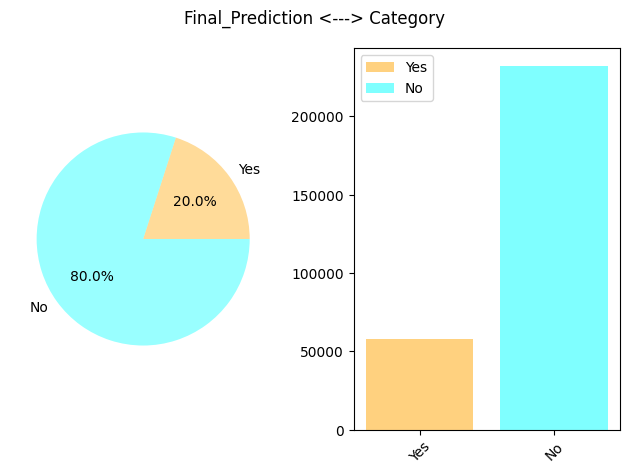

In [28]:
vz.feature(population_1['Final_Prediction'])

#### Encoding and loading data into the sampler which is used for sampling in future.

In [29]:
encoded = prep.encode(population_1)
sampler.load(encoded, 'Final_Prediction')

#### Creation of models which is used throughout

In [30]:
dt = DecisionTreeClassifier()
pipe.load('Decision Tree',dt)
rf = RandomForestClassifier(n_estimators=20, random_state=42, class_weight='balanced')
pipe.load('Random Forest',rf)
xg = xgb.XGBClassifier()
pipe.load('XG-Boost', xg)
nn = Sequential([
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    
nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
pipe.load('Neural Networks', nn)

#### Random Sampling

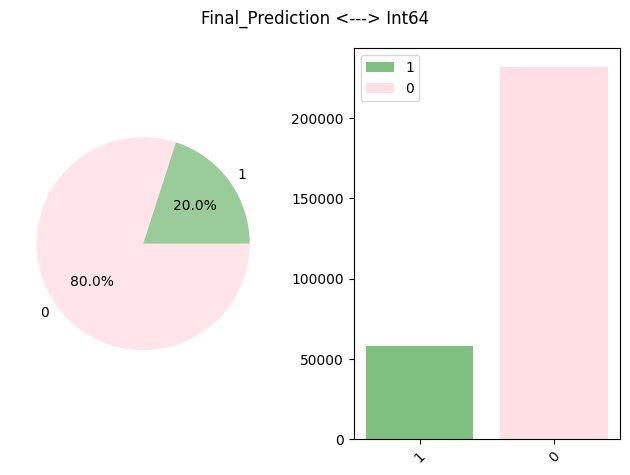

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.77      0.80      0.79     67116
           1       0.23      0.20      0.21     19859

    accuracy                           0.66     86975
   macro avg       0.50      0.50      0.50     86975
weighted avg       0.65      0.66      0.65     86975




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     86862
           1       0.00      0.27      0.00       113

    accuracy                           0.80     86975
   macro avg       0.50      0.53      0.45     86975
weighted avg       1.00      0.80      0.89     86975




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     86918
           1       0.00      0.16      0.00        57

    accuracy                           0.80     8

In [31]:
dt_X, dt_y = sampler.random_sampling(population_1.shape[0])
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after random sampling

In [32]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,10.7,11.1
1,Age,12.4,12.7
2,Gender,0.7,1.6
3,Smoking_Status,3.1,3.4
4,Second_Hand_Smoke,1.6,1.8
5,Air_Pollution_Exposure,1.1,3.1
6,Occupation_Exposure,1.7,1.9
7,Rural_or_Urban,1.7,1.7
8,Socioeconomic_Status,3.0,3.2
9,Healthcare_Access,2.6,3.5


#### Random Sampling with Replacement.

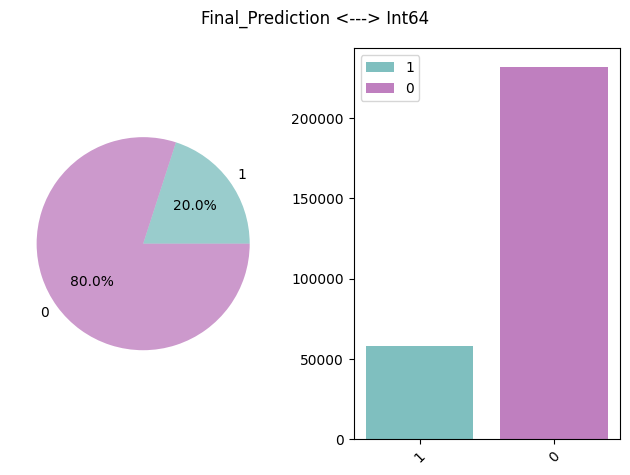

In [33]:
dt_X, dt_y = sampler.sampling_w_replacement(weighted=False)
vz.feature(dt_y)

Random noise added: 2


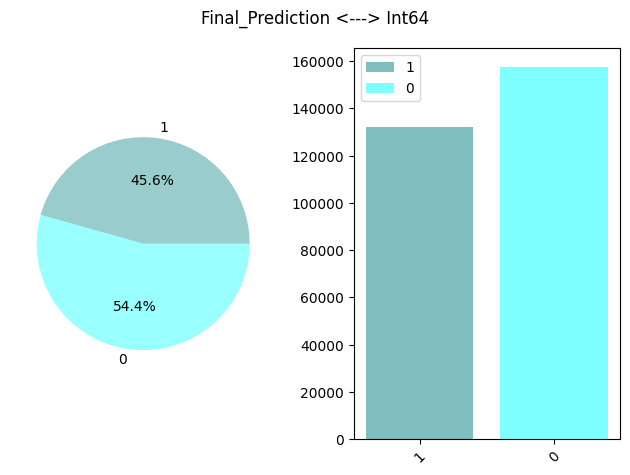

In [34]:
dt_X, dt_y = sampler.sampling_w_replacement(weighted=True)
vz.feature(dt_y)

Random noise added: 3


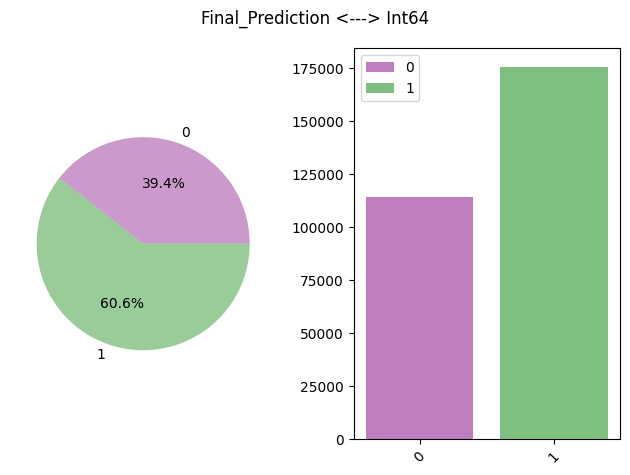

In [35]:
dt_X, dt_y = sampler.sampling_w_replacement(weighted=True)
vz.feature(dt_y)

Random noise added: 4


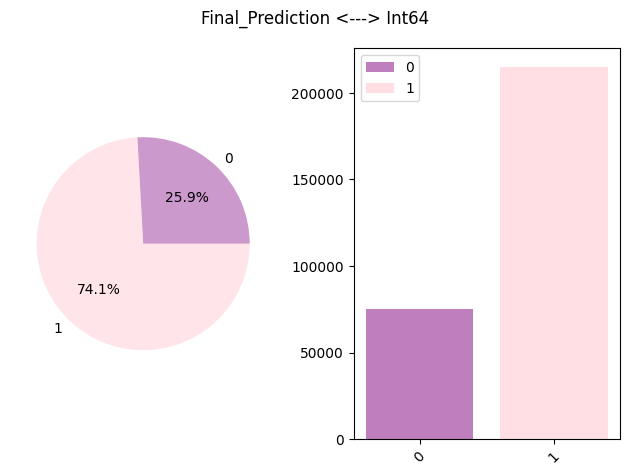

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.59      0.85      0.70     15681
           1       0.96      0.87      0.91     71294

    accuracy                           0.87     86975
   macro avg       0.78      0.86      0.81     86975
weighted avg       0.90      0.87      0.88     86975




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       0.40      0.88      0.55     10296
           1       0.98      0.82      0.90     76679

    accuracy                           0.83     86975
   macro avg       0.69      0.85      0.72     86975
weighted avg       0.91      0.83      0.85     86975




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       0.02      0.74      0.05       744
           1       1.00      0.74      0.85     86231

    accuracy                           0.74     8

In [36]:
dt_X, dt_y = sampler.sampling_w_replacement(weighted=True)
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after random sampling with replacement.

In [37]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,10.3,11.1
1,Age,12.6,12.6
2,Gender,1.9,2.2
3,Smoking_Status,3.2,3.2
4,Second_Hand_Smoke,1.7,1.7
5,Air_Pollution_Exposure,2.8,3.4
6,Occupation_Exposure,1.7,1.8
7,Rural_or_Urban,0.0,1.4
8,Socioeconomic_Status,2.8,3.5
9,Healthcare_Access,2.1,3.4


#### Stratified Sampling

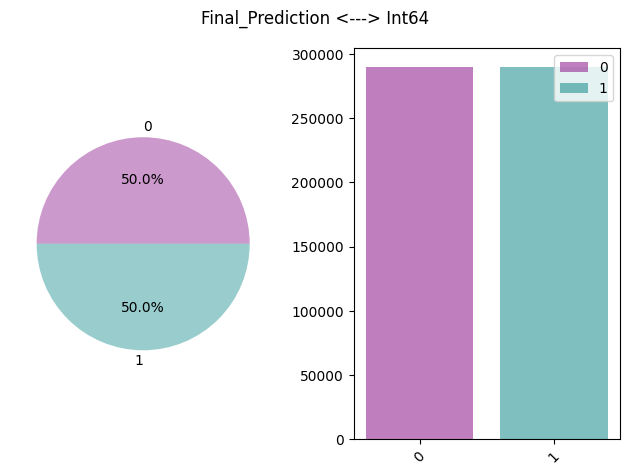

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     78226
           1       0.98      0.89      0.93     95724

    accuracy                           0.93    173950
   macro avg       0.93      0.93      0.93    173950
weighted avg       0.93      0.93      0.93    173950




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     87589
           1       0.97      0.97      0.97     86361

    accuracy                           0.97    173950
   macro avg       0.97      0.97      0.97    173950
weighted avg       0.97      0.97      0.97    173950




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       0.59      0.61      0.60     84469
           1       0.62      0.61      0.61     89481

    accuracy                           0.61    17

In [38]:
dt_X, dt_y = sampler.stratified_eq_sampling(population_1.shape[0])
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after stratified sampling

In [39]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,11.2,11.0
1,Age,12.8,12.9
2,Gender,0.7,1.5
3,Smoking_Status,3.1,3.6
4,Second_Hand_Smoke,1.7,1.9
5,Air_Pollution_Exposure,1.1,3.0
6,Occupation_Exposure,1.6,1.8
7,Rural_or_Urban,1.8,1.8
8,Socioeconomic_Status,2.8,3.4
9,Healthcare_Access,2.5,3.5


#### SMOTE

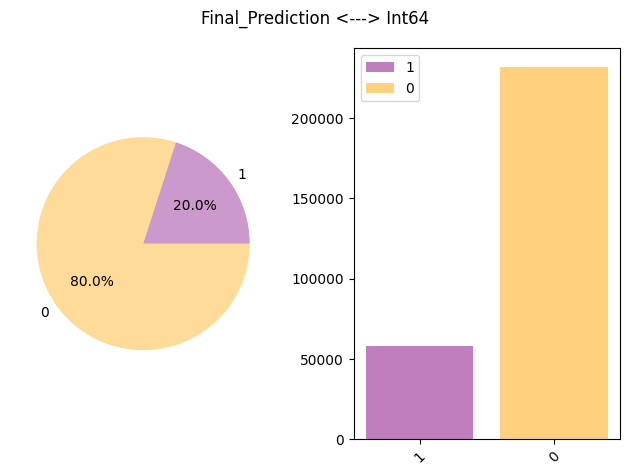

In [40]:
dt_X, dt_y = sampler.random_sampling(population_1.shape[0])
vz.feature(dt_y)

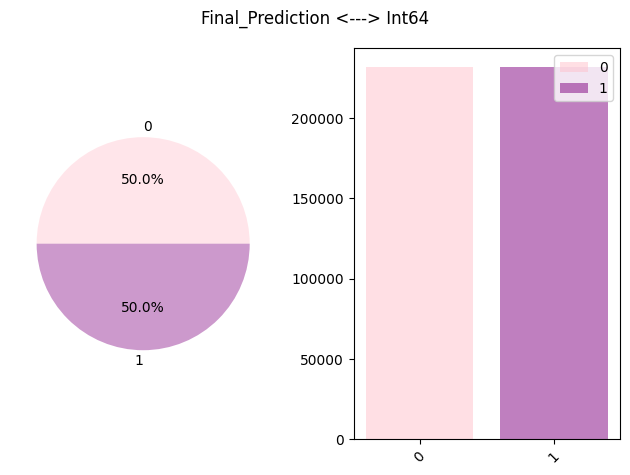

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.64      0.68      0.66     65558
           1       0.69      0.66      0.68     73550

    accuracy                           0.67    139108
   macro avg       0.67      0.67      0.67    139108
weighted avg       0.67      0.67      0.67    139108




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       0.80      0.75      0.78     74604
           1       0.73      0.79      0.76     64504

    accuracy                           0.77    139108
   macro avg       0.77      0.77      0.77    139108
weighted avg       0.77      0.77      0.77    139108




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     70844
           1       0.70      0.71      0.71     68264

    accuracy                           0.71    13

In [41]:
dt_X, dt_y = sampler.smote(dt_X, dt_y, sampling = 'minority', neighbors = 3)
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after SMOTE sampling

In [42]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,12.2,11.5
1,Age,14.0,12.7
2,Gender,1.6,1.7
3,Smoking_Status,3.1,3.7
4,Second_Hand_Smoke,1.6,1.7
5,Air_Pollution_Exposure,2.9,3.3
6,Occupation_Exposure,1.6,1.8
7,Rural_or_Urban,1.7,2.1
8,Socioeconomic_Status,3.1,3.5
9,Healthcare_Access,3.1,3.5


## Part 2: Dropping collumns containing null values and repeating the earlier process.

In [43]:
population_2 = _df.drop(columns=['Mutation_Type', 'Treatment_Access'])
population_2

,Country,Age,Gender,Smoking_Status,Second_Hand_Smoke,Air_Pollution_Exposure,Occupation_Exposure,Rural_or_Urban,Socioeconomic_Status,Healthcare_Access,...,Cancer_Type,Clinical_Trial_Access,Language_Barrier,Mortality_Risk,5_Year_Survival_Probability,Delay_in_Diagnosis,Family_History,Indoor_Smoke_Exposure,Tobacco_Marketing_Exposure,Final_Prediction
0,Russia,82,Male,Former Smoker,Yes,Medium,No,Urban,High,Limited,...,NSCLC,Yes,No,0.263278,0.797576,Yes,No,No,No,No
1,Thailand,66,Female,Former Smoker,No,High,No,Rural,Middle,Good,...,NSCLC,Yes,No,0.154697,0.336674,Yes,No,No,Yes,No
2,Colombia,87,Male,Former Smoker,No,Medium,No,Urban,Low,Poor,...,NSCLC,Yes,No,0.607435,0.063621,No,No,No,Yes,No
3,Egypt,51,Female,Former Smoker,No,Low,Yes,Rural,High,Good,...,NSCLC,No,No,0.081184,0.336814,No,No,No,Yes,No
4,DR Congo,43,Male,Former Smoker,No,High,No,Urban,Middle,Good,...,NSCLC,No,No,0.643276,0.820103,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460287,Russia,46,Female,Former Smoker,Yes,Medium,No,Urban,Middle,Poor,...,NSCLC,No,No,0.794849,0.521195,No,No,No,No,Yes
460288,Pakistan,63,Female,Non-Smoker,No,Low,No,Urban,Middle,Good,...,NSCLC,No,No,0.198008,0.907028,No,No,No,No,Yes
460289,Germany,51,Female,Smoker,No,Low,No,Urban,High,Poor,...,NSCLC,No,No,0.491532,0.866276,Yes,Yes,No,Yes,No
460290,Italy,83,Female,Former Smoker,No,Low,No,Urban,Middle,Good,...,SCLC,No,No,0.077730,0.610409,No,No,No,No,Yes


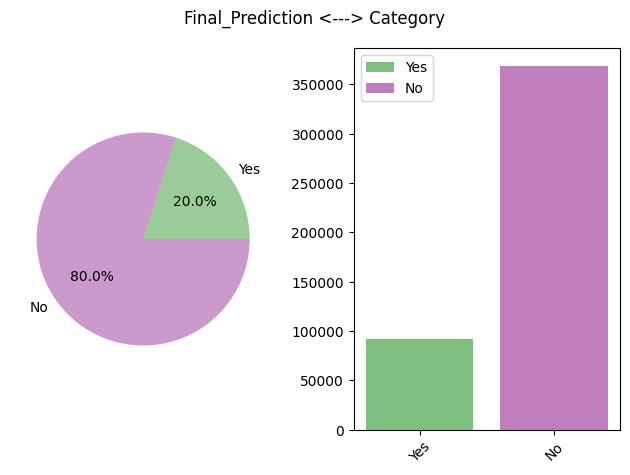

In [44]:
vz.feature(population_2['Final_Prediction'])

#### Encoding and loading data into the sampler which is used for sampling in future.

In [45]:
encoded = prep.encode(population_2)
sampler.load(encoded, 'Final_Prediction')

In [46]:
pipe.unload('Neural Networks')

In [47]:
nn = Sequential([
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    
nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
pipe.load('Neural Networks', nn)

#### Random Sampling

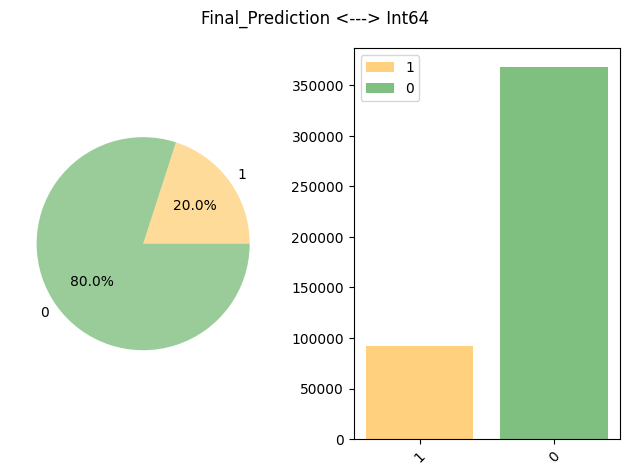

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.77      0.80      0.78    106525
           1       0.23      0.20      0.21     31563

    accuracy                           0.66    138088
   macro avg       0.50      0.50      0.50    138088
weighted avg       0.65      0.66      0.65    138088




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    137885
           1       0.00      0.20      0.00       203

    accuracy                           0.80    138088
   macro avg       0.50      0.50      0.44    138088
weighted avg       1.00      0.80      0.89    138088




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    138045
           1       0.00      0.23      0.00        43

    accuracy                           0.80    13

In [48]:
dt_X, dt_y = sampler.random_sampling(population_2.shape[0])
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after random sampling

In [49]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,9.9,11.6
1,Age,12.0,13.9
2,Gender,2.1,2.2
3,Smoking_Status,3.1,3.4
4,Second_Hand_Smoke,1.5,1.9
5,Air_Pollution_Exposure,3.3,3.3
6,Occupation_Exposure,1.3,1.6
7,Rural_or_Urban,1.7,1.9
8,Socioeconomic_Status,3.0,3.4
9,Healthcare_Access,2.5,3.3


#### Random Sampling with Replacement.

Random noise added: 1


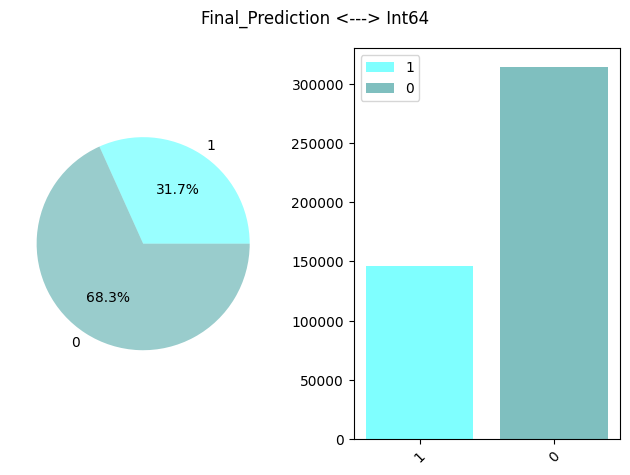

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     89257
           1       0.77      0.69      0.73     48831

    accuracy                           0.82    138088
   macro avg       0.80      0.79      0.79    138088
weighted avg       0.81      0.82      0.81    138088




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       0.99      0.87      0.92    107798
           1       0.67      0.97      0.79     30290

    accuracy                           0.89    138088
   macro avg       0.83      0.92      0.86    138088
weighted avg       0.92      0.89      0.89    138088




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    136534
           1       0.02      0.64      0.04      1554

    accuracy                           0.69    13

In [50]:
dt_X, dt_y = sampler.sampling_w_replacement(weighted=True)
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after random sampling with replacement.

In [51]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,10.3,11.3
1,Age,12.3,13.6
2,Gender,1.5,2.0
3,Smoking_Status,3.6,3.6
4,Second_Hand_Smoke,1.5,1.8
5,Air_Pollution_Exposure,1.1,3.0
6,Occupation_Exposure,1.7,1.9
7,Rural_or_Urban,2.0,2.0
8,Socioeconomic_Status,3.5,3.5
9,Healthcare_Access,3.0,3.2


#### Stratified Sampling

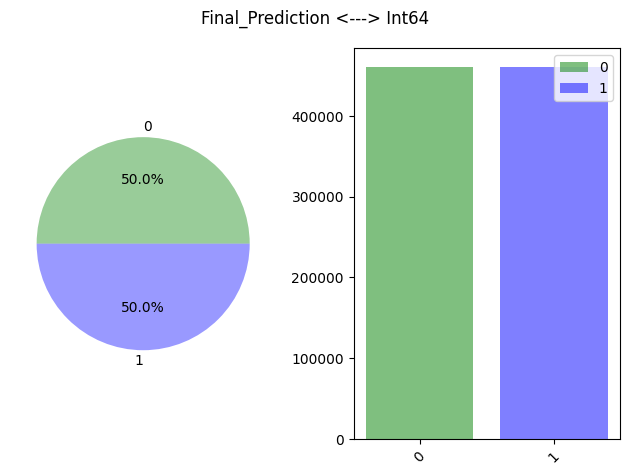

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.92    123449
           1       0.98      0.89      0.93    152727

    accuracy                           0.93    276176
   macro avg       0.93      0.93      0.93    276176
weighted avg       0.93      0.93      0.93    276176




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    138331
           1       0.97      0.97      0.97    137845

    accuracy                           0.97    276176
   macro avg       0.97      0.97      0.97    276176
weighted avg       0.97      0.97      0.97    276176




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       0.58      0.58      0.58    137423
           1       0.59      0.59      0.59    138753

    accuracy                           0.58    27

In [52]:
dt_X, dt_y = sampler.stratified_eq_sampling(population_2.shape[0])
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after stratified sampling 

In [53]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,10.3,12.0
1,Age,12.3,13.5
2,Gender,1.1,1.8
3,Smoking_Status,3.2,3.5
4,Second_Hand_Smoke,1.9,1.9
5,Air_Pollution_Exposure,1.5,2.8
6,Occupation_Exposure,1.9,1.9
7,Rural_or_Urban,1.7,2.1
8,Socioeconomic_Status,2.9,3.5
9,Healthcare_Access,2.7,3.2


#### SMOTE

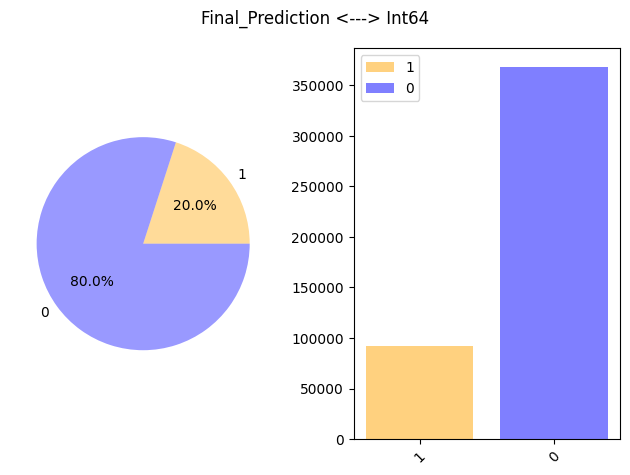

In [54]:
dt_X, dt_y = sampler.random_sampling(population_2.shape[0])
vz.feature(dt_y)

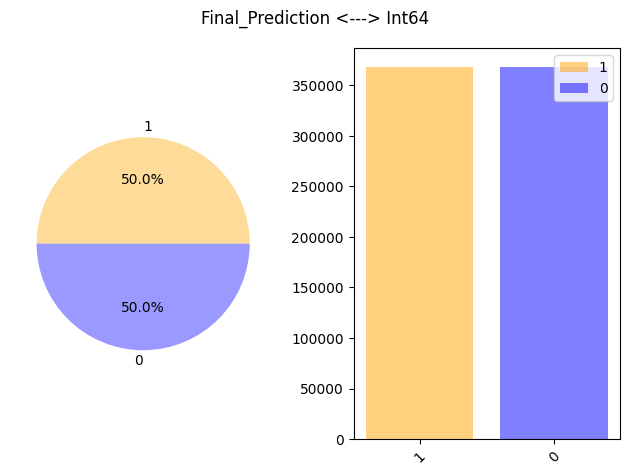

---------------Decision Tree---------------
              precision    recall  f1-score   support

           0       0.62      0.66      0.64    104501
           1       0.68      0.64      0.66    116364

    accuracy                           0.65    220865
   macro avg       0.65      0.65      0.65    220865
weighted avg       0.65      0.65      0.65    220865




---------------Random Forest---------------
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    116493
           1       0.72      0.77      0.74    104372

    accuracy                           0.75    220865
   macro avg       0.75      0.75      0.75    220865
weighted avg       0.75      0.75      0.75    220865




---------------XG-Boost---------------
              precision    recall  f1-score   support

           0       0.68      0.68      0.68    110453
           1       0.68      0.68      0.68    110412

    accuracy                           0.68    22

In [55]:
dt_X, dt_y = sampler.smote(dt_X, dt_y, sampling = 'minority', neighbors = 3)
pipe.initialize(dt_X, dt_y, prep.normalize, 0.3)
vz.feature(dt_y)
pipe.process()

#### Feature importance by decision tree and random forest after SMOTE sampling 

In [56]:
prep.display({'Features': encoded.columns[:-1], 'Importance by Desicion tree': np.round(dt.feature_importances_,3) * 100, 'Importance by Random forest': np.round(rf.feature_importances_,3) * 100})

,Features,Importance by Desicion tree,Importance by Random forest
0,Country,13.1,13.2
1,Age,15.5,14.7
2,Gender,1.4,1.4
3,Smoking_Status,3.3,3.6
4,Second_Hand_Smoke,1.2,1.5
5,Air_Pollution_Exposure,2.8,3.3
6,Occupation_Exposure,1.3,1.5
7,Rural_or_Urban,1.9,1.9
8,Socioeconomic_Status,3.3,3.6
9,Healthcare_Access,3.0,3.2


### Example references